In [3]:
from afinn import Afinn
import json
import pandas as pd
import nltk
import re
from scipy.stats import chi2_contingency

Stemming tester

In [ ]:
stemmer = nltk.stem.PorterStemmer()
stemmer.stem("compared")

In [4]:
category_map = {
   # "Amazon_Instant_Video" : 0,
   # "Apps_for_Android" : 1,
   # "Automotive" : 2,
   # "Baby" : 3,
   # "Beauty" : 4,
   # "Books" : 5,
#     "CDs_and_Vinyl" : 6,
#     "Cell_Phones_and_Accessories" : 7,
#     "Clothing_Shoes_and_Jewelry" : 8,
#     "Digital_Music" : 9,
#    "Electronics" : 10
#     "Grocery_and_Gourmet_Food" : 11,
#     "Health_and_Personal_Care" : 12,
#     "Home_and_Kitchen" : 13,
#     "Kindle_Store" : 14,
#     "Movies_and_TV" : 15,
#     "Musical_Instruments" : 16,
     "Office_Products" : 17,
#     "Patio_Lawn_and_Garden" : 18,
#     "Pet_Supplies" : 19,
#     "Sports_and_Outdoors" : 20,
#     "Tools_and_Home_Improvement" : 21,
    "Toys_and_Games" : 22,
#     "Video_Games" : 23
}

col_names = ["reviewer_id", "asin", "summary","review_text", "overall", "category", "total_votes","upvotes","score",
             "good", "bad"]

def read_dataset():
    data =[]
    for category in category_map:
        fn = category + "_"+"5" + ".json"
        print("Reading category", category)
        with open(fn) as f:
            for line in f:
                d = json.loads(line)
                pf, tf = d["helpful"]
                if tf > 5 and len(d["reviewText"].split()) > 10:
                    score = int(pf) / int(tf)
                    row = [d["reviewerID"], 
                           d["asin"], 
                           d["summary"],
                           d["reviewText"],
                           d["overall"],
                           category_map[category],
                           int(tf),
                           int(pf),
                           (score),
                           int(score >= 0.80),
                           int(score <= 0.20)]
                    data.append(row)
                    
    return pd.DataFrame(data, columns=col_names)

df = read_dataset()

Reading category Toys_and_Games


Created a text richness field, distinct words in text over total words.

In [5]:
def text_richness(text):
    return len(set(text.split()))/len(text.split())

df['text_richness'] = df.review_text.apply(lambda x: text_richness(x))

Creating an AFINN sentiment score

In [6]:
afinn  = Afinn(emoticons=True)
df['afinn'] = df.review_text.apply(lambda x: afinn.score(x))
df.head()

,reviewer_id,asin,summary,review_text,overall,category,total_votes,upvotes,score,good,bad,text_richness,afinn
0,A2XU46XXNV19C8,0439893577,Nifty little thing,I keep this board on top of the hallway table ...,3.0,22,59,59,1.000000,1,0,0.842105,11.0
1,A3AJWITG95EY0Q,0439893577,Every child should have this!,We had purchased Melissa & Doug magnets & had ...,5.0,22,19,17,0.894737,1,0,0.786517,4.0
2,A1X3ESYZ79H59E,048645195X,Beautiful designs,This book contains 30 full page designs that a...,5.0,22,8,7,0.875000,1,0,0.931034,8.0
3,AKMEY1BSHSDG7,048645195X,Takes a delicate touch!,Prepare to be swept away by the beauty of the ...,5.0,22,13,11,0.846154,1,0,0.773333,15.0
4,AKU1TXYBJKSV6,048645195X,"Beautiful designs, but not good for markers",I just recieved my copy of decorative tile des...,3.0,22,6,5,0.833333,1,0,0.767442,24.0


count    12714.000000
mean         0.702156
std          0.111282
min          0.311144
25%          0.625506
50%          0.697368
75%          0.775489
max          1.000000
Name: text_richness, dtype: float64

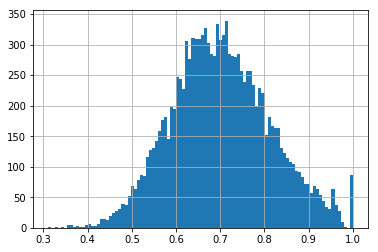

In [7]:
df_positive = df[(df.total_votes - df.upvotes)/df.total_votes <= 0.7]
df_positive.text_richness.hist(bins=100)
df_positive.text_richness.describe()

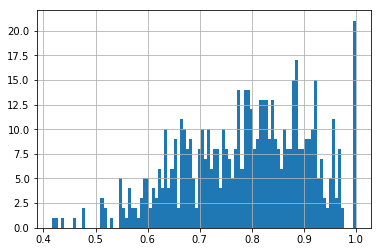

In [8]:
df_negative = df[(df.total_votes - df.upvotes)/df.total_votes > 0.7]
df_negative.text_richness.hist(bins=100)

In [9]:
df_negative.text_richness.describe() 

count    581.000000
mean       0.788227
std        0.119566
min        0.416021
25%        0.704918
50%        0.800000
75%        0.882353
max        1.000000
Name: text_richness, dtype: float64

In [80]:
df['neg_pc'] = (df.total_votes - df.upvotes)/df.total_votes

Creating an image flag for posts containing images

In [113]:
image_regex = 'picture[s]?|attach[ed|ment]|image[s]?'
df['image_flag'] = [1 if x else 0 for x in df.review_text.str.contains(image_regex, regex=True, case=0)]
df.head()

,reviewer_id,asin,summary,review_text,overall,category,total_votes,upvotes,score,good,bad,text_richness,afinn,avg_word_len,image_flag
0,A2XU46XXNV19C8,0439893577,Nifty little thing,I keep this board on top of the hallway table ...,3.0,22,59,59,1.000000,1,0,0.842105,11.0,3.769231,0
1,A3AJWITG95EY0Q,0439893577,Every child should have this!,We had purchased Melissa & Doug magnets & had ...,5.0,22,19,17,0.894737,1,0,0.786517,4.0,4.090909,0
2,A1X3ESYZ79H59E,048645195X,Beautiful designs,This book contains 30 full page designs that a...,5.0,22,8,7,0.875000,1,0,0.931034,8.0,4.720000,0
3,AKMEY1BSHSDG7,048645195X,Takes a delicate touch!,Prepare to be swept away by the beauty of the ...,5.0,22,13,11,0.846154,1,0,0.773333,15.0,4.303797,1
4,AKU1TXYBJKSV6,048645195X,"Beautiful designs, but not good for markers",I just recieved my copy of decorative tile des...,3.0,22,6,5,0.833333,1,0,0.767442,24.0,4.390977,0


Images in post seem to be highly relevant to hulpfulness

In [128]:
pd.crosstab(df.good, df.image_flag)
chi2_contingency(pd.crosstab(df.good, df.image_flag))

image_flag,0,1
good,,
0,3295,370
1,8302,1328


(32.198386459192008,
 1.3920631401125236e-08,
 1,
 array([[ 3196.91650997,   468.08349003],
        [ 8400.08349003,  1229.91650997]]))

Creating average word length for the post

In [40]:
def process_text(text, stem_in = True):
    # lowercase
    # remove symbols
    RE_PREPROCESS = r'\W+|\d+'  
#get rid of punctuation and make everything lowercase
    text = re.sub(RE_PREPROCESS, ' ', text).lower()
    if stem_in:
        return stemmer.stem(text)
    return text

def total_characters(fd):
    sum = 0
    for v,k in fd.items():
        sum += (v*k)
    return sum

def word_length_avg(text):
    fd = nltk.FreqDist(len(w) for w in process_text(text).split())
    return total_characters(fd)/fd.N()

In [38]:
df['avg_word_len'] = df.review_text.apply(lambda x: word_length_avg(x))
df.head()

In [164]:
df.corr()

,overall,category,total_votes,upvotes,score,good,bad,text_richness,afinn,avg_word_len,image_flag
overall,1.000000,NaN,0.005897,0.043250,0.403012,0.327884,-0.234046,-0.036391,0.281303,0.041881,-0.017240
category,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_votes,0.005897,NaN,1.000000,0.991322,0.098994,0.114969,-0.013541,-0.160450,0.147573,0.055791,0.036784
upvotes,0.043250,NaN,0.991322,1.000000,0.168978,0.163669,-0.072392,-0.167366,0.161192,0.056481,0.040149
score,0.403012,NaN,0.098994,0.168978,1.000000,0.789924,-0.654775,-0.183252,0.187960,0.069640,0.056634
good,0.327884,NaN,0.114969,0.163669,0.789924,1.000000,-0.298119,-0.126697,0.150212,0.052407,0.049502
bad,-0.234046,NaN,-0.013541,-0.072392,-0.654775,-0.298119,1.000000,0.146850,-0.115091,-0.067865,-0.038718
text_richness,-0.036391,NaN,-0.160450,-0.167366,-0.183252,-0.126697,0.146850,1.000000,-0.503810,-0.059764,-0.211515
afinn,0.281303,NaN,0.147573,0.161192,0.187960,0.150212,-0.115091,-0.503810,1.000000,0.131743,0.130692
avg_word_len,0.041881,NaN,0.055791,0.056481,0.069640,0.052407,-0.067865,-0.059764,0.131743,1.000000,0.065152


In [166]:
df.head()

,reviewer_id,asin,summary,review_text,overall,category,total_votes,upvotes,score,good,bad,text_richness,afinn,avg_word_len,image_flag
2,A1X3ESYZ79H59E,048645195X,Beautiful designs,This book contains 30 full page designs that a...,5.0,22,8,7,0.875000,1,0,0.931034,8.0,4.720000,0
3,AKMEY1BSHSDG7,048645195X,Takes a delicate touch!,Prepare to be swept away by the beauty of the ...,5.0,22,13,11,0.846154,1,0,0.773333,15.0,4.303797,1
4,AKU1TXYBJKSV6,048645195X,"Beautiful designs, but not good for markers",I just recieved my copy of decorative tile des...,3.0,22,6,5,0.833333,1,0,0.767442,24.0,4.390977,0
5,A1UQ9JZLKLAO7X,0545496470,Book of impossible objects,This book looks really fun and cool. Haven't o...,4.0,22,6,0,0.000000,0,1,0.923077,8.0,3.846154,0
6,ADGYS9FJ3G8SG,0545496470,lots of stuff,Bought this book for my optical illusion obses...,3.0,22,20,5,0.250000,0,0,0.881356,5.0,4.180328,0
